In [1]:
from huggingface_hub import hf_hub_download
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from transformer_lens import HookedTransformer
model_name = "EleutherAI/pythia-70m-deduped"

model = HookedTransformer.from_pretrained(model_name, device=device)

Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [4]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "JeanKaddour/minipile"
token_amount= 40
#TODO: change train[:1000] to train if you want whole dataset
# 100_000 datasets
# I think that we want to use the full 100_000 at some point...
# dataset = load_dataset(dataset_name, split="train[:100000]").map(
dataset = load_dataset(dataset_name, split="train[:1000]").map( # 1_000 to get started
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)
# TODO: we can maybe make this faster for the larger dataset?

Found cached dataset parquet (/home/lev/.cache/huggingface/datasets/JeanKaddour___parquet/JeanKaddour--minipile-0d7d2d1ff79d1d36/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/994 [00:00<?, ? examples/s]

In [5]:
setting = "mlp_out"

def get_cache_name_neurons(layer: int):
    if setting == "residual":
        cache_name = f"blocks.{layer}.hook_resid_post"
        neurons = model.cfg.d_model
    elif setting == "mlp":
        cache_name = f"blocks.{layer}.mlp.hook_post"
        neurons = model.cfg.d_mlp
    elif setting == "attention":
        cache_name = f"blocks.{layer}.hook_attn_out"
        neurons = model.cfg.d_model
    elif setting == "mlp_out":
        cache_name = f"blocks.{layer}.hook_mlp_out"
        neurons = model.cfg.d_model
    else:
        raise NotImplementedError
    return cache_name, neurons

In [6]:
n_layers = model.cfg.n_layers
model.cfg.d_model, n_layers

(512, 6)

# Get Dictionary Activations

In [7]:
# TODO: in chunks...
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from datasets import DatasetDict
from tqdm.auto import tqdm
from einops import rearrange
import math

# MAX_CHUNK_SIZE = 1_000

# TODO: move to a separate file or something
def get_activations(layer: int):
    datapoints = dataset.num_rows
    embedding_size = model.cfg.d_model
    activations_final = np.memmap(f'layer-{layer}.mymemmap', dtype='float32', mode='w+', shape=(datapoints, token_amount, embedding_size))
    batch_size = 32

    with torch.no_grad(), dataset.formatted_as("pt"):
        dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
        cache_name = get_cache_name_neurons(layer)[0]
        for i, batch in enumerate(tqdm(dl)):
            # print(batch)
            _, cache = model.run_with_cache(batch.to(device))
            # print("AA", cache[cache_name].shape)
            # batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )

            real_batch_size = batch.shape[0]
            activations_final[i*batch_size:i*batch_size + real_batch_size, :, :] = cache[cache_name].cpu().numpy()
    return activations_final

dict_activations = [get_activations(layer) for layer in range(n_layers)]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

## Perform (Kernel trick???) K-Means on each layer

In [8]:
from sklearn.cluster import KMeans
import numpy as np

# TODO: how to find right # of clusters
n_clusters = 100

def create_kmeans(dict_act):
	assert len(dict_act.shape) == 3
	# Flatten the array
	dict_act = dict_act.reshape(-1, dict_act.shape[-1])
	kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(dict_act)
	return kmeans.labels_, kmeans.cluster_centers_

In [9]:
# Perform kmeans on all the clusters
kmeans_rets = [create_kmeans(dict_act) for dict_act in dict_activations]
kmeans_labels = [kmeans_rets[i][0] for i in range(len(kmeans_rets))]
kmeans_cluster_center = [kmeans_rets[i][1] for i in range(len(kmeans_rets))]

In [11]:
!pip install fcapy[all] --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
import pandas as pd

def to_one_hot(nparr: np.ndarray, n_clusters: int=n_clusters):
	b = np.zeros((nparr.size, n_clusters), dtype=np.int8)
	b[np.arange(nparr.size), nparr] = 1
	# return b == 1
	return b

def create_concepts_table(kmeans_labels):
	one_hots = [to_one_hot(kmeans_labels[i]) for i in range(len(kmeans_labels))]
	concat = np.concatenate(one_hots, axis=1)
	print("DF shape of", concat.shape)
	col_labels = [str(s) for s in range(concat.shape[0])]

	return pd.DataFrame(data=concat, columns=[str(s) for s in range(concat.shape[1])], index=col_labels)

df = create_concepts_table(kmeans_labels)

DF shape of (39760, 600)


In [39]:
df[:10]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df.to_csv('data_test_1.csv', header=True, index=True, sep=',', mode='a')

In [ ]:
# For conexp-clj
# (def ctx-1 (read-context "data_test_1.csv" :named-binary-csv))
# (def lat-1 (concept-lattice ctx-1))... kinda slow...

In [26]:
# url = 'https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/animal_movement.csv'
# pd.read_csv(url, index_col=0)

In [29]:
import matplotlib.pyplot as plt
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx

L = ConceptLattice.from_context(K)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
vsl = LineVizNx()
vsl.draw_concept_lattice(L, ax=ax, flg_node_indices=True)
ax.set_title('"Animal movement" concept lattice', fontsize=18)
plt.tight_layout()
plt.show()

## Build the 2-depth Concept Lattice
<!-- TODO: general depth -->

In [ ]:
datapoints = dataset.num_rows
num_features_prior, _ = autoencoder_prior.encoder.shape
num_features_main, _ = autoencoder_main.encoder.shape

graph = np.memmap(f'graph_{layer_focus}.mymemmap', dtype='float32', mode='w+', shape=(num_features_main, num_features_prior))

for i in range(num_features_main):
		graph[i,:] = np.zeros(num_features_prior)

In [ ]:
eps = 0.001

for i in range(datapoints):
	d_prior = dict_activations_prior[i]
	d_main = dict_activations_main[i]
	for main_feat in range(num_features_main):
		# If there is an activation of the main feature **anywhere** in the prior token stream then we want to add it to the graph
		if d_main[:, main_feat].sum() > eps:
			# TODO: this is failing to look at whats going on with self-attention
			# TODO: okay maybe we can do something like ~~reconstruct~~ whole token sequence from the dictionary then feed this forward
			# Hmmmm is it enough to just sum along the axis???
			# This gives overall ~~vibe~~ relation but nothing more?
			graph[main_feat] += d_prior.sum(axis=0)

KeyboardInterrupt: 

In [ ]:
# We have this many "dead" features (i.e. never activated by this dataset)
(graph.sum(axis=1) == 0).sum()

112

In [ ]:
# TODO: hmmm. The `graph` is data-set dependent so we want to renormalize
graph = graph / graph.sum(axis=1, keepdims=True)

/tmp/ipykernel_198951/1174004706.py:2: RuntimeWarning: invalid value encountered in divide
  graph = graph / graph.sum(axis=1, keepdims=True)


In [ ]:
epsCutoff = 0.005

graphCutoff = np.nan_to_num((graph >= epsCutoff) * graph)

Feature has 11 connections


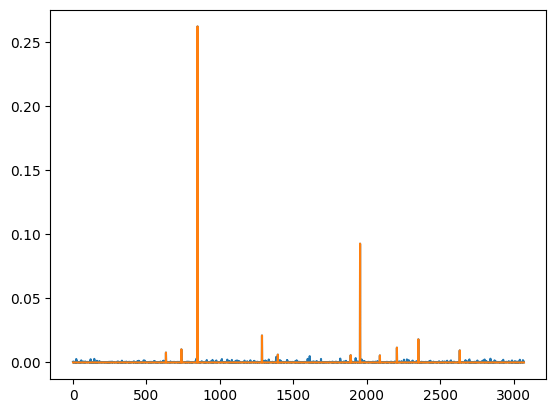

In [ ]:
# Check how "sparse" the graph is
import matplotlib.pyplot as plt

# 10 has **a bunch** of connections
# feature = 10

feature = 9

max_features = np.argsort(graphCutoff[feature])[::-1]
# print(max_features[:10].tolist(), graphCutoff[feature][max_features][:10].tolist())
print(f"Feature has {graphCutoff[feature].nonzero()[0].shape[-1]} connections")

# print(graph[feature], dict_activations_prior.sum())
plt.plot(graph[feature])
plt.plot(graphCutoff[feature])

In [ ]:
n_features_per_neuron_no_cutoff = []
n_features_per_neuron = []
for i in range(num_features_main):
	n_features = graph[i].nonzero()[0].shape[-1]
	n_features_per_neuron_no_cutoff.append(n_features)
	n_features = graphCutoff[i].nonzero()[0].shape[-1]
	n_features_per_neuron.append(n_features)
	if graphCutoff[i].sum() == 0:
		if graph[i].sum() > 0:
			print(f"Feature {i} has no connections in cutoff but {graph[i].sum()} connections in non-cutoff")
		else:
			print(f"Feature {i} has no connections at all! This is a dead neuron!")

Feature 25 has no connections at all! This is a dead neuron!
Feature 37 has no connections at all! This is a dead neuron!
Feature 127 has no connections at all! This is a dead neuron!
Feature 136 has no connections at all! This is a dead neuron!
Feature 141 has no connections at all! This is a dead neuron!
Feature 147 has no connections at all! This is a dead neuron!
Feature 194 has no connections at all! This is a dead neuron!
Feature 198 has no connections at all! This is a dead neuron!
Feature 210 has no connections at all! This is a dead neuron!
Feature 226 has no connections at all! This is a dead neuron!
Feature 237 has no connections at all! This is a dead neuron!
Feature 299 has no connections at all! This is a dead neuron!
Feature 311 has no connections at all! This is a dead neuron!
Feature 318 has no connections at all! This is a dead neuron!
Feature 421 has no connections at all! This is a dead neuron!
Feature 441 has no connections at all! This is a dead neuron!
Feature 47

In [ ]:
# Layer 1 maxes out at 36 inputs
# Layer 2 maxes out at 19 inputs
# Layer 3 maxes out at 22 inputs

print(f"Feature space has {max(n_features_per_neuron)}")
print(f"Non interfering feature space has {max(n_features_per_neuron_no_cutoff)}")

Feature space has 19
Non interfering feature space has 3072


## Some Graphing

In [ ]:
INCLUDE_WEIGHTS = True
PRIOR_ON_RIGHT = False
GRAPH_SIZE_MAIN = 30
D_NEIGHBORS = 20

In [ ]:
main_feats = np.random.choice(num_features_main, GRAPH_SIZE_MAIN, replace=False)

[1875 2997  460 1574 2186  810 1573 1614 2584 2224  941  163  769 1975
  732 2615 1968 1119  358 2909 1556  954 1330 1967 2141  972 1269 2757
 2565  783]
NO EDGE FOR FEATURE 1574
NO EDGE FOR FEATURE 732
NO EDGE FOR FEATURE 2141


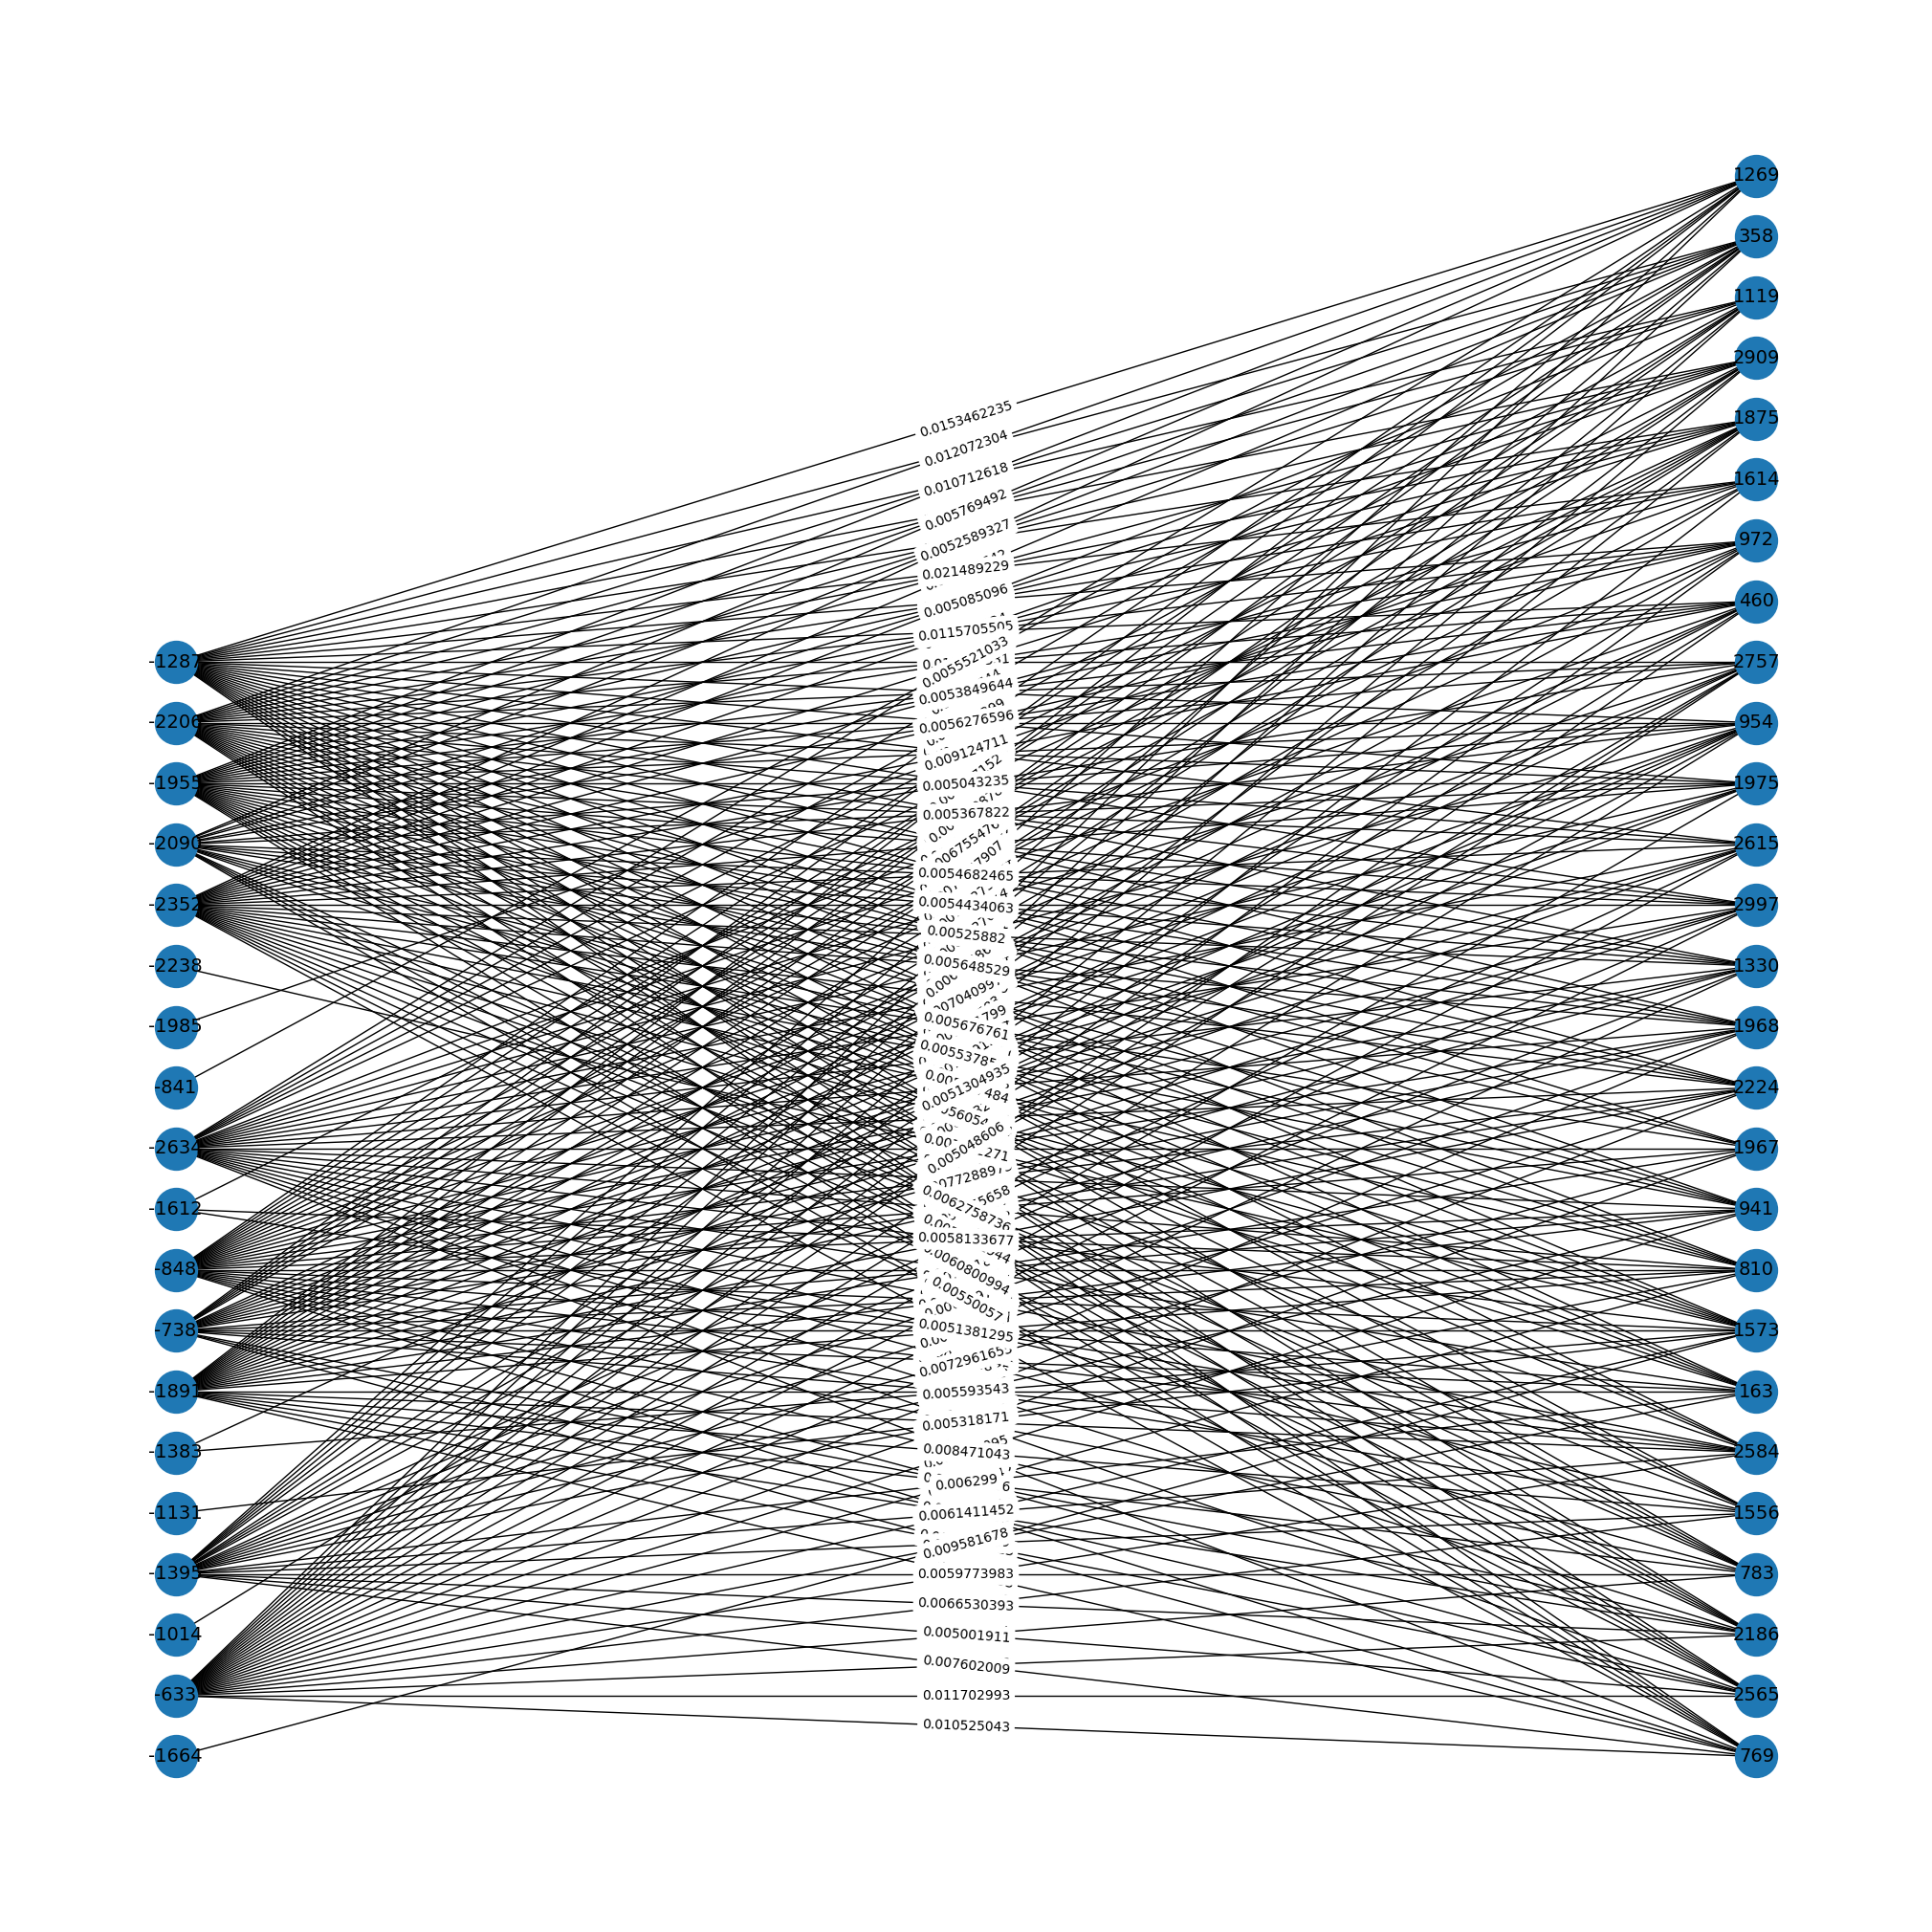

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# main_feats = np.random.choice(np.nonzero(graphCutoff.sum(axis=1))[0], GRAPH_SIZE_MAIN, replace=False)
print(main_feats)
prior_feats = np.nonzero(graphCutoff[main_feats])[1]

randomGraphProjection = graphCutoff[main_feats][:,prior_feats]


# Create a new bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
# nodes_u = set((prior_feats * -1).tolist())  # Set of nodes V
# nodes_v = main_feats.tolist() # Set of nodes U
# B.add_nodes_from(nodes_u, bipartite=0)  # Label one set of nodes 0
# B.add_nodes_from(nodes_v, bipartite=1)  # Label the other set of nodes 1

edges = []

for main in main_feats:
	has_edge = False
	# nonzerod = graphCutoff[main].nonzero()[0]
	args = np.argsort(graphCutoff[main])[::-1][:D_NEIGHBORS]
	# print(args, graphCutoff[main][args])
	for prior in args:
		if graphCutoff[main][prior] > 0:
			if INCLUDE_WEIGHTS:
				edges.append((prior * -1, main, graphCutoff[main][prior]))
			else:
				edges.append((prior * -1, main))
			has_edge = True
	# for j in range(prior_feats.shape[-1]):
	# 	if randomGraphProjection[i,j] > 0:
	# 		print("Adding edge")
	# 		edges.append((prior_feats[j], main_feats[i], randomGraphProjection[i,j]))
	# 		has_edge = True
	if not has_edge:
		print("NO EDGE FOR FEATURE", main)
# Add edges with weights
if INCLUDE_WEIGHTS:
	B.add_weighted_edges_from(edges)
else:
	B.add_edges_from(edges)

# Separate by group
l, r = nx.bipartite.sets(B)

if PRIOR_ON_RIGHT:
	# Reverse the sets so that the LHS is the prior
	l, r = r, l
pos = {}

# Update position for node from each group
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

# Draw the graph
plt.figure(1, figsize=(20, 20))
nx.draw(B, pos, with_labels=True, node_size=1_000, font_size=14)

# Draw edge labels
edge_labels = nx.get_edge_attributes(B, 'weight')

if INCLUDE_WEIGHTS:
	nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)
else:
	pass
plt.show()

## Utils

In [ ]:
from interp_utils import *
from circuitsvis.activations import text_neuron_activations
import torch
import numpy as np
from einops import rearrange

# Get the activations for the best dict features
def get_feature_datapoints_with_idx(feature_index, dictionary_activations, tokenizer, token_amount, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, :, feature_index].flatten()
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = np.argsort(best_feature_activations)[:k]
        # found_indices = np.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = np.min(best_feature_activations)
        max_value = np.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = np.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        # TODO: hmm
        # np bucketize?
        # bins = torch.bucketize(best_feature_activations, bin_boundaries)
        bins = np.digitize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in np.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = np.array(np.nonzero(bins == bin_idx)).squeeze(axis=0)
            # print(bin_indices.shape)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = np.flip(np.array(sampled_indices), axis=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    num_datapoints = int(dictionary_activations.shape[0])
    datapoint_indices =[np.unravel_index(i, (num_datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list, found_indices

## Some interpretability with GPT-4 and **context**

In [ ]:
from interp_utils import get_neuron_activation

def get_activations_for_text(feature_idx : int, t : str):
	split_text = model.to_str_tokens(t, prepend_bos=False)
	token = model.to_tokens(t, prepend_bos=False)
	_a = get_neuron_activation(token, feature_idx, model, autoencoder_prior, layer_focus - 1, setting="dictionary_basis")
	return _a

print(get_activations_for_text(1321, "1 + 1"))

2023-11-13 10:39:48.710644: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 10:39:48.847383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 10:39:49.372256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[0.0, 0.0, 0.0]


In [ ]:
# From https://github.com/openai/automated-interpretability/blob/main/neuron-explainer/neuron_explainer/explanations/explainer.py


ROLE_NO_PRIOR = "We're studying neurons in a neural network. Each neuron looks for some particular" + \
"thing in a short document. Look at the parts of the document the neuron activates for " + \
"and summarize in a single sentence what the neuron is looking for. Don't list " + \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " + \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " + \
"non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does."
 

ROLE_YES_PRIOR = "We're studying neurons in a neural network. Each neuron looks for some particular" + \
"thing in a short document. Look at the parts of the document the neuron activates for " + \
"and summarize in a single sentence what the neuron is looking for. We will also give neural concepts which are upstream of what the current neuron is looking for. The upstream concepts should play a role in what the current neuron is looking for. " +\
"Don't list " + \
"examples of words.\n\nThe activation format is token<tab>activation. Activation " + \
"values range from 0 to 10. A neuron finding what it's looking for is represented by a " + \
"non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does."
 


def get_samples_and_act_for_feature(feature_idx: int, autoencoder, layer: int, dict_activations, n_samples=10):
	# TODO: max prob
	text_list, _, _, _, _ = get_feature_datapoints_with_idx(feature_idx, dict_activations, model.tokenizer, token_amount, dataset, setting="uniform", k=n_samples)
	split_texts = []
	activations = []
	max_act = -1
	min_act = 1e10
	for t in text_list:
		split_text = model.to_str_tokens(t, prepend_bos=False)
		token = model.to_tokens(t, prepend_bos=False)
		_a = get_neuron_activation(token, feature_idx, model, autoencoder, layer, setting="dictionary_basis")
		acts = np.array(_a)
		if acts.sum() > 0:
			# Rescale to between 0 and 10
			# activations.append((acts - acts.min()) / ((acts.max() - acts.min()) / 10))
			if acts.max() > max_act:
				max_act = acts.max()
			if acts.min() < min_act:
				min_act = acts.min()

			activations.append(acts)
			split_texts.append(split_text)
	
	for i in range(len(activations)):
		activations[i] = (activations[i] - min_act) / ((max_act - min_act) / 10)
		activations[i] = activations[i].tolist()
	return split_texts, activations



# TODO: integrate with auto-inter?
def create_prompt(feature_idx: int, autoencoder, layer, dict, n_samples=10, prior_feature_description=None):
	# TODO: Adjust k!!
	texts, acts = get_samples_and_act_for_feature(feature_idx, autoencoder=autoencoder,
																							 layer=layer, dict_activations=dict, n_samples=n_samples)	
	entries = []
	for t, a in zip(texts, acts):
		e = []
		# print("TEXT:", t)
		# print("ACTIVATION:", a)
		for tok, act in zip(t, a):
			e.append(f"{tok}\t{act}")
		joined = '\n'.join(e)
		entries.append(f"<start>\n{joined}\n<end>")
	joined = "\n".join(entries)
	if prior_feature_description is not None:
		upstream_concepts = "\n\n".join(prior_feature_description)
		return f"""{ROLE_YES_PRIOR}

Neuron {feature_idx}
Activations:
{joined}


Upstream Neuron Concepts:
{upstream_concepts}
"""
	else:
		return f"""{ROLE_NO_PRIOR}

Neuron {feature_idx}
Activations:
{joined}

"""

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
from langchain.chat_models import ChatOpenAI

# Cool we found a hard-to-understand feature
feature = 32
s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=20)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)

We're studying neurons in a neural network. Each neuron looks for some particularthing in a short document. Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is looking for. Don't list examples of words.

The activation format is token<tab>activation. Activation values range from 0 to 10. A neuron finding what it's looking for is represented by a non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does.

Neuron 32
Activations:
<start>
Elect	0.0
romy	0.0
ographic	0.0
 analysis	0.0
 of	0.0
 del	10.0
<end>
<start>
Del	7.850600196810368
ano	0.7952788088991631
 Municipal	0.0
 Airport	0.12905560681103878

	0.0

	0.0
Del	9.514092675079334
<end>
<start>
South	0.0
 Bay	0.0
 comm	0.0
uters	0.0
 looking	0.0
 to	0.0
 avoid	0.0
 the	0.0
 405	0.0
 Free	0.0
way	0.0
 have	0.0
 long	0.0
 taken	0.0
 an	0.0
 alternate	0.0
 route	0.0
 through	0.0
 Play	0.0
a	0.0
 del	9.463315012281

(None,
 AIMessage(content='The neuron is looking for the token "del" or "Del".', additional_kwargs={}, example=False))

In [ ]:
F_T = 2830
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(F_T, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=10)
visualize_text(text_list, F_T, model, autoencoder_main, layer_focus)

## Try to use the concept lattice to inform the feature description

In [ ]:
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(556, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform", k=10)
visualize_text(text_list, 556, model, autoencoder_prior, layer_focus - 1)

In [ ]:
# Cool we found a hard-to-understand feature
feature = 32

# Cool we found a hard-to-understand feature
# feature = 2830

# feature = 2685

def get_upstream_features(feature) -> list[int]:
	return graphCutoff[feature].nonzero()[0].tolist()
get_upstream_features(feature)

[633, 738, 848, 1287, 1395, 1891, 1955, 2090, 2206, 2352, 2634]

In [ ]:

def get_descr_prior(feature) -> str:
	s = create_prompt(feature, autoencoder_prior, layer_focus - 1, dict_activations_prior, n_samples=20)
	llm = ChatOpenAI(model_name='gpt-4')
	c = llm.invoke(input=s).content
	print("upstream feature description:", c)
	return c

upstream_descr = [get_descr_prior(f) for f in get_upstream_features(feature)]

s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=40, prior_feature_description=upstream_descr)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)
# TODO: if no activations, resample or something.... (or lets sample larger idk)... need to figure out this uniform thing
# Need to fix the distr thing with sampling... (like maybe use max but remove subset strs)

upstream feature description: Neuron 633 appears to be looking for punctuation marks and short forms in the text.
upstream feature description: The neuron is looking for the term "memory" in the context of a semiconductor memory device.
upstream feature description: The neuron is looking for the start of a new line or section in a document.
upstream feature description: The neuron is looking for specific words and symbols often related to legal terms, programming code, and instances of violence or horror.
upstream feature description: The neuron is looking for academic or scientific terms related to specific departments, areas of research, and roles within those areas.
upstream feature description: The neuron is looking for verbs and related grammatical elements, such as tense and aspect, in a short document.
upstream feature description: The neuron is looking for the start of sections, statements, or comments in the document.
upstream feature description: Neuron 2090 is looking for lo

(None,
 AIMessage(content='Neuron 32 is looking for the occurrence of the word "del" in a variety of contexts, seemingly unrelated to upstream concepts.', additional_kwargs={}, example=False))

In [ ]:
# Without priors

#feature = 2685
s = create_prompt(feature, autoencoder_main, layer_focus, dict_activations_main, n_samples=40, prior_feature_description=None)
llm = ChatOpenAI(model_name='gpt-4')
print(s), llm.invoke(input=s)

We're studying neurons in a neural network. Each neuron looks for some particularthing in a short document. Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is looking for. Don't list examples of words.

The activation format is token<tab>activation. Activation values range from 0 to 10. A neuron finding what it's looking for is represented by a non-zero activation value. The higher the activation value, the stronger the match. Only respond with what the neuron does.

Neuron 32
Activations:
<start>
Elect	0.0
romy	0.0
ographic	0.0
 analysis	0.0
 of	0.0
 del	10.0
<end>
<start>
Last	0.0
 Thursday	0.0
 at	0.0
 Comic	0.0
-	0.0
Con	0.0
,	0.0
 Gu	0.0
ill	0.0
ermo	0.0
 del	9.990445372297831
<end>
<start>
El	0.0
 princip	0.0
io	0.0
 del	9.666787702638397
<end>
<start>
Emer	0.0
gency	0.0
 declaration	0.0
 allows	0.0
 for	0.0
 broad	0.0
 coordination	0.0
 of	0.0
 state	0.0
 agencies	0.0
 to	0.0
 respond	0.7760362936915143
 to	0.0
 outbr

(None,
 AIMessage(content='The neuron is looking for the presence of the term "Del" (del).', additional_kwargs={}, example=False))

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [ ]:
dict_activations_prior.shape

(9862, 40, 3072)

In [ ]:
feature_idx = 20
text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_prior, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus - 1)

In [ ]:
feature_idx = 2447

text_list, full_text, token_list, full_token_list, sampled_indices = get_feature_datapoints_with_idx(feature_idx, dict_activations_main, model.tokenizer, token_amount, dataset, setting="uniform", k=100)
visualize_text(text_list, feature_idx, model, autoencoder_prior, layer_focus)

KeyboardInterrupt: 